<a href="https://colab.research.google.com/github/nicolasvazquez95/Aprendiendo_DeepLearning/blob/main/04_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Jan 21 20:37:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Download data
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-01-21 20:37:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.211.128, 173.194.212.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.211.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   265MB/s    in 0.6s    

2022-01-21 20:37:28 (265 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import tensorflow as tf
from tensorflow import keras as keras
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# TensorBoard Callback

In [ ]:
import datetime
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving Tensorboard log files to {log_dir}')
  return tensorboard_callback

In [ ]:
# Get the pretrained models from TF Hub
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
efficientnet_url = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'

import tensorflow_hub as hub
from keras import layers

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_history = resnet_model.fit(train_data,
                 epochs=10,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback('tensorflow_hub','resnet50v2')])

Saving Tensorboard log files to tensorflow_hub/resnet50v2/20220121-203739
Epoch 1/10
24/24 [==============================] - 32s 795ms/step - loss: 1.9922 - accuracy: 0.3360 - val_loss: 1.2474 - val_accuracy: 0.5988
Epoch 2/10
24/24 [==============================] - 17s 718ms/step - loss: 0.9221 - accuracy: 0.7147 - val_loss: 0.8908 - val_accuracy: 0.7092
Epoch 3/10
24/24 [==============================] - 17s 734ms/step - loss: 0.6386 - accuracy: 0.8200 - val_loss: 0.7715 - val_accuracy: 0.7488
Epoch 4/10
24/24 [==============================] - 17s 741ms/step - loss: 0.4906 - accuracy: 0.8587 - val_loss: 0.7058 - val_accuracy: 0.7688
Epoch 5/10
24/24 [==============================] - 17s 738ms/step - loss: 0.3876 - accuracy: 0.9067 - val_loss: 0.6827 - val_accuracy: 0.7768
Epoch 6/10
24/24 [==============================] - 18s 756ms/step - loss: 0.3210 - accuracy: 0.9413 - val_loss: 0.6640 - val_accuracy: 0.7800
Epoch 7/10
24/24 [==============================] - 17s 736ms/step -

In [ ]:
# Plot the validation and training data separately
from matplotlib import pyplot as plt
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(13,6))

  ax1.plot(epochs, loss,'--o', label='training_loss')
  ax1.plot(epochs, val_loss,'--o', label='val_loss')
  ax1.set_title('Loss')
  ax1.set_xlabel('Epochs')
  ax1.grid()
  ax1.legend()

  # Plot accuracy
  ax2.plot(epochs, accuracy,'--o', label='training_accuracy')
  ax2.plot(epochs, val_accuracy,'--o', label='val_accuracy')
  ax2.set_title('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.grid()
  ax2.legend();

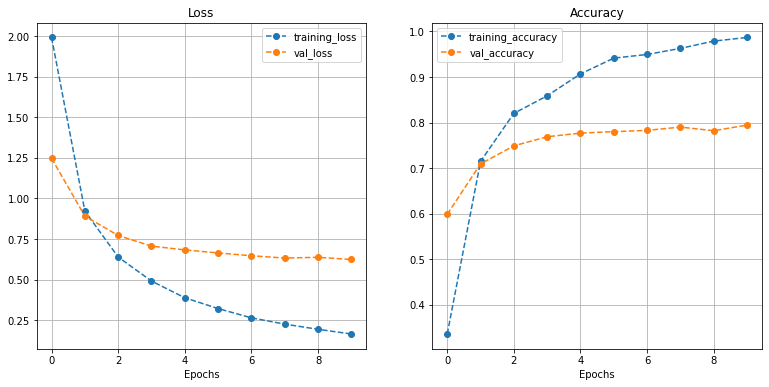

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
# Efficient Net pretrained model
efficient_model = create_model(efficientnet_url)

efficient_model.compile(loss='categorical_crossentropy',
                        optimizer=keras.optimizers.Adam(),
                        metrics=['accuracy'])

In [ ]:
efficient_history = efficient_model.fit(train_data,epochs=10,steps_per_epoch=len(train_data),
                    validation_data=test_data,validation_steps=len(test_data),
                    callbacks=[create_tensorboard_callback('tensorflow_hub','efficientnetb0')])

Saving Tensorboard log files to tensorflow_hub/efficientnetb0/20220121-204050
Epoch 1/10
24/24 [==============================] - 21s 751ms/step - loss: 1.7715 - accuracy: 0.5107 - val_loss: 1.2403 - val_accuracy: 0.7532
Epoch 2/10
24/24 [==============================] - 16s 686ms/step - loss: 1.0195 - accuracy: 0.8040 - val_loss: 0.8414 - val_accuracy: 0.8244
Epoch 3/10
24/24 [==============================] - 16s 678ms/step - loss: 0.7317 - accuracy: 0.8573 - val_loss: 0.6834 - val_accuracy: 0.8484
Epoch 4/10
24/24 [==============================] - 16s 684ms/step - loss: 0.5897 - accuracy: 0.8827 - val_loss: 0.6008 - val_accuracy: 0.8568
Epoch 5/10
24/24 [==============================] - 16s 695ms/step - loss: 0.4999 - accuracy: 0.8973 - val_loss: 0.5473 - val_accuracy: 0.8656
Epoch 6/10
24/24 [==============================] - 16s 685ms/step - loss: 0.4350 - accuracy: 0.9107 - val_loss: 0.5152 - val_accuracy: 0.8712
Epoch 7/10
24/24 [==============================] - 16s 678ms/st

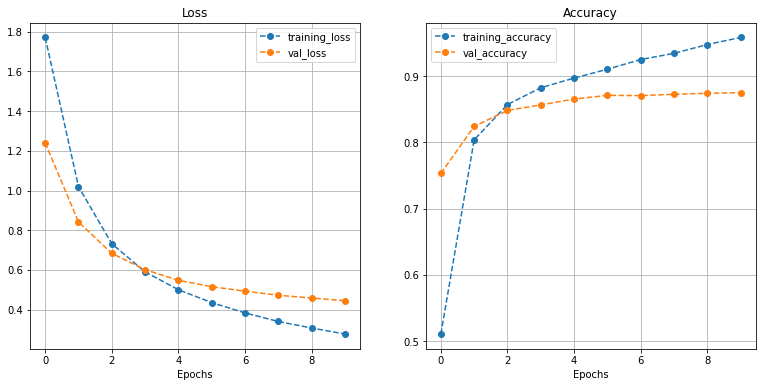

In [ ]:
plot_loss_curves(efficient_history)

# TensorBoard



In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ --name "Efficient vs. ResNet" \
  --description "Comparing 2 TF_HUB feature extraction model architectures" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=jTsGf8yyY4BOYc8hbXPSSFTVIaNp5j&prompt=consent&access_type=off

# Exercises
Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction ([mobilenet_v2_100_224/feature_vector](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5)) from TensorFlow Hub, how does it perform compared to our other models?

In [ ]:
mobilenet_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5'
mobilenet_model = create_model(mobilenet_url)

mobilenet_model.compile(loss='categorical_crossentropy',
                        optimizer=keras.optimizers.Adam(),
                        metrics=['accuracy'])

In [ ]:
mobilenet_model.fit(train_data,epochs=10,
                    callbacks=[create_tensorboard_callback('tensorflow_hub','MobileNet')],
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,validation_steps=len(test_data),
                    )

Saving Tensorboard log files to tensorflow_hub/MobileNet/20220121-212607
Epoch 1/10
24/24 [==============================] - 21s 741ms/step - loss: 2.0961 - accuracy: 0.2840 - val_loss: 1.3690 - val_accuracy: 0.5928
Epoch 2/10
24/24 [==============================] - 16s 694ms/step - loss: 1.1166 - accuracy: 0.6653 - val_loss: 0.9100 - val_accuracy: 0.7388
Epoch 3/10
24/24 [==============================] - 16s 695ms/step - loss: 0.7654 - accuracy: 0.7920 - val_loss: 0.7698 - val_accuracy: 0.7648
Epoch 4/10
24/24 [==============================] - 16s 695ms/step - loss: 0.6104 - accuracy: 0.8480 - val_loss: 0.6972 - val_accuracy: 0.7892
Epoch 5/10
24/24 [==============================] - 16s 693ms/step - loss: 0.5162 - accuracy: 0.8773 - val_loss: 0.6403 - val_accuracy: 0.8020
Epoch 6/10
24/24 [==============================] - 16s 699ms/step - loss: 0.4312 - accuracy: 0.9013 - val_loss: 0.6368 - val_accuracy: 0.8000
Epoch 7/10
24/24 [==============================] - 16s 684ms/step - 

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ --name "Efficient vs. ResNet vs. MobileNet" \
  --description "Comparing 3 TF_HUB feature extraction model architectures" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/kYlr6u7bRb6TgFKD1UJ8tg/

[2022-01-21T21:30:37] Started scanning logdir.
[2022-01-21T21:30:40] Total uploaded: 180 scalars, 0 tensors, 3 binary objects (4.7 MB)
[2022-01-21T21:30:40] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/kYlr6u7bRb6TgFKD1UJ8tg/
